In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
%matplotlib inline

In [3]:
df = pd.read_csv('data/linear-regression-ml-data.csv')
df.describe()

,Debt/EBITDA,FFO/Debt (%),EBITDA/Interest,Debt/Capital,FCF/Debt (%),Total Debt (M),EBITDA (M)
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,1.343333,25.592982,80.439532,0.490515,70.118713,14049.567251,10953.099415
std,4.101113,70.120716,686.998519,0.525115,197.812856,18312.542792,23241.058212
min,-45.220000,0.600000,-17.600000,-3.207000,-31.900000,40.000000,-7649.000000
25%,1.115000,8.150000,8.340000,0.270500,17.350000,3281.000000,1913.500000
50%,1.790000,12.000000,12.410000,0.400000,32.000000,7580.000000,4139.000000
75%,2.575000,18.150000,20.645000,0.600500,57.150000,17686.500000,9473.500000
max,3.770000,861.700000,8973.520000,3.281000,2220.600000,121381.000000,160165.000000


In [4]:
df.head()

,Ticker,Debt/EBITDA,FFO/Debt (%),EBITDA/Interest,Debt/Capital,FCF/Debt (%),Total Debt (M),EBITDA (M),Credit Rating
0,SJM,-45.22,7.1,-0.40,0.536,11.6,7037,-156,BBB
1,CCI,-18.91,7.4,-1.38,1.006,7.3,23471,-1241,BB
2,BA,-6.85,3.5,-2.81,1.081,-27.5,52433,-7649,BBB
3,ALB,-3.09,18.9,-6.10,0.238,-31.5,3118,-1010,AA
4,TTWO,-0.84,53.4,-17.60,0.540,-8.5,2513,-2980,BBB


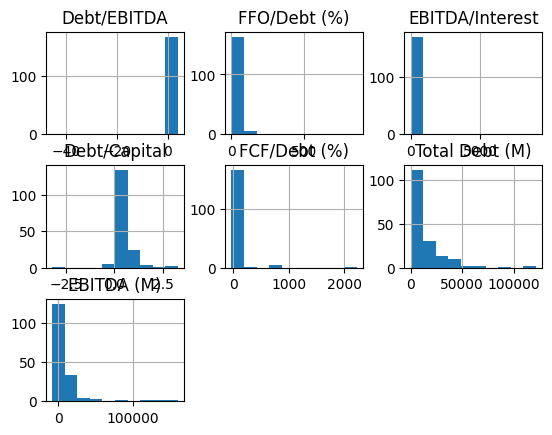

In [5]:
df.hist()
plt.show()

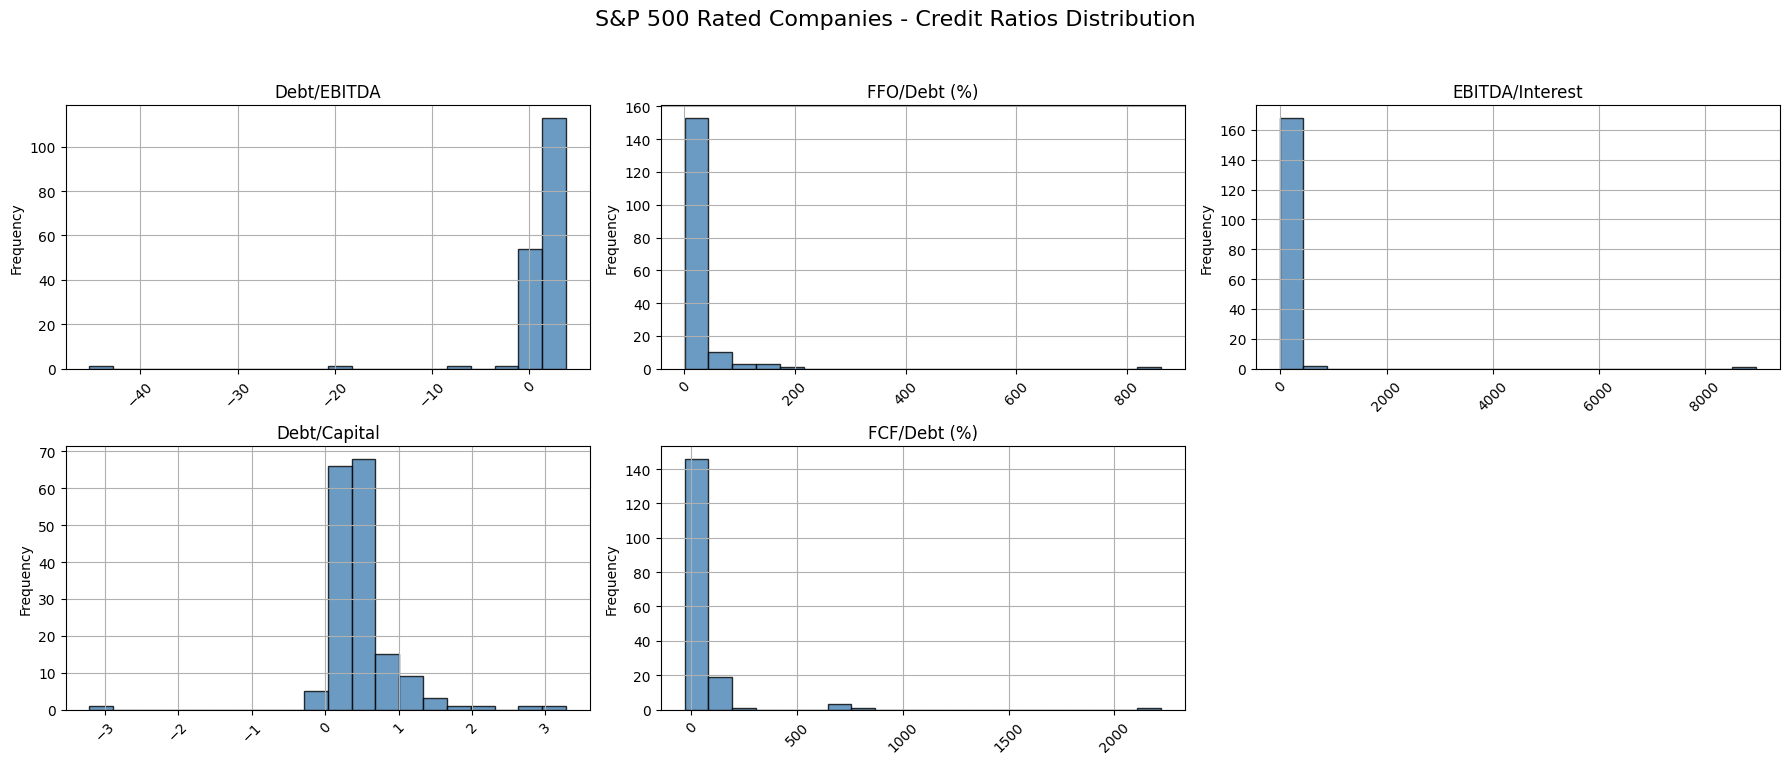

In [6]:
# Select only the key numeric credit ratio columns (optional, cleaner)
# Remove non-numeric or irrelevant columns like Ticker, ratings string, etc.
numeric_cols = ['Debt/EBITDA', 'FFO/Debt (%)', 'EBITDA/Interest', 
                'Debt/Capital', 'FCF/Debt (%)']

df_numeric = df[numeric_cols]

# Create larger figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))  # Wide and tall
fig.suptitle('S&P 500 Rated Companies - Credit Ratios Distribution', fontsize=16, y=0.98)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    ax = axes[i]
    df_numeric[col].hist(bins=20, ax=ax, color='steelblue', edgecolor='black', alpha=0.8)
    ax.set_title(col, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')
    
    # Rotate x-tick labels to prevent overlap
    ax.tick_params(axis='x', rotation=45)
    
    # Optional: tighter layout for long labels
    ax.ticklabel_format(style='plain', axis='x')  # Avoid scientific notation

# Hide empty subplots (if fewer than 9 columns)
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle

plt.show()

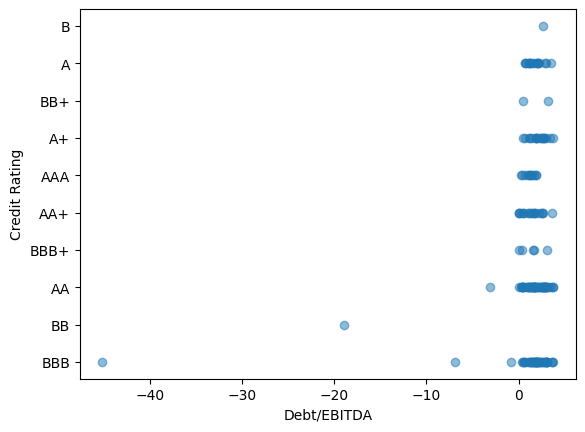

In [7]:
plt.scatter(df['Debt/EBITDA'], df['Credit Rating'], alpha=0.5)
plt.xlabel("Debt/EBITDA")
plt.ylabel("Credit Rating")
plt.show()

In [8]:
df.shape

(171, 9)

Rows after filtering Debt/EBITDA >= -1: 167 (removed 4)


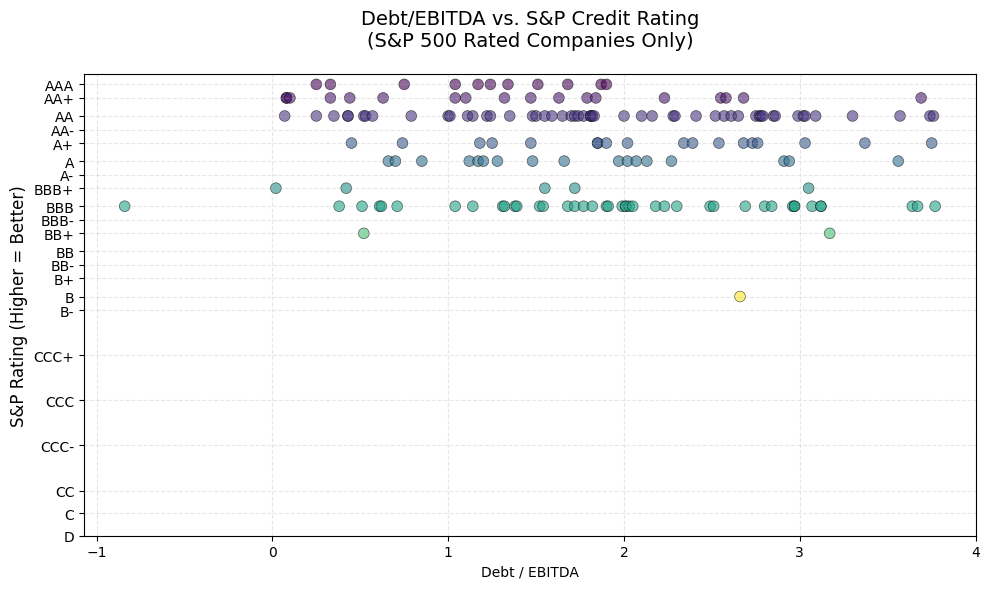

In [9]:
# === Step 1: Filter out extreme negative Debt/EBITDA (< -1) ===
df_plot = df[df['Debt/EBITDA'] >= -1].copy()

print(f"Rows after filtering Debt/EBITDA >= -1: {len(df_plot)} (removed {len(df) - len(df_plot)})")

# === Step 2: Map S&P ratings to numeric scores (higher = better rating) ===
rating_order = {
    'AAA': 10,
    'AA+': 9.7,
    'AA': 9.3,
    'AA-': 9,
    'A+': 8.7,
    'A': 8.3,
    'A-': 8,
    'BBB+': 7.7,
    'BBB': 7.3,
    'BBB-': 7,
    'BB+': 6.7,
    'BB': 6.3,
    'BB-': 6,
    'B+': 5.7,
    'B': 5.3,
    'B-': 5,
    'CCC+': 4,
    'CCC': 3,
    'CCC-': 2,
    'CC': 1,
    'C': 0.5,
    'D': 0
}

# Apply mapping (unmapped ratings → NaN, will be skipped)
df_plot['Rating Score'] = df_plot['Credit Rating'].map(rating_order)

# Drop any unmapped ratings (safety)
df_plot = df_plot.dropna(subset=['Rating Score', 'Debt/EBITDA'])

# === Step 3: Create the scatter plot ===
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_plot['Debt/EBITDA'],
    df_plot['Rating Score'],
    alpha=0.6,
    c=df_plot['Rating Score'],
    cmap='viridis_r',  # Reverse viridis: higher rating = brighter/yellower
    s=60,
    edgecolors='black',
    linewidth=0.5
)

# Customize y-axis with rating labels
plt.yticks(list(rating_order.values()), list(rating_order.keys()))
plt.ylabel('S&P Rating (Higher = Better)', fontsize=12)
plt.xlabel('Debt / EBITDA', fontsize=10)
plt.title('Debt/EBITDA vs. S&P Credit Rating\n(S&P 500 Rated Companies Only)', fontsize=14, pad=20)

# Add grid for readability
plt.grid(True, alpha=0.3, linestyle='--')

# Tight layout
plt.tight_layout()
plt.show()

#### Train data distribution


In [10]:
mapping = pd.read_csv('data/credit-rating-mapping.csv')

In [11]:
df['Avg. 1-Year PD (%)'] = df['Credit Rating'].map(mapping.set_index('Rating')['Avg. 1-Year PD (%)'])

In [12]:
df.head()

,Ticker,Debt/EBITDA,FFO/Debt (%),EBITDA/Interest,Debt/Capital,FCF/Debt (%),Total Debt (M),EBITDA (M),Credit Rating,Avg. 1-Year PD (%)
0,SJM,-45.22,7.1,-0.40,0.536,11.6,7037,-156,BBB,0.28
1,CCI,-18.91,7.4,-1.38,1.006,7.3,23471,-1241,BB,0.89
2,BA,-6.85,3.5,-2.81,1.081,-27.5,52433,-7649,BBB,0.28
3,ALB,-3.09,18.9,-6.10,0.238,-31.5,3118,-1010,AA,0.02
4,TTWO,-0.84,53.4,-17.60,0.540,-8.5,2513,-2980,BBB,0.28


#### Creating train and test dataset
Let's split our dataset into train and test sets. 80% of the entire dataset will be used for training and 20% for testing. We create a mask to select random rows using __np.random.rand()__ function: 


In [13]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [14]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Debt/EBITDA']])
train_y = np.asanyarray(train[['Avg. 1-Year PD (%)']])
regr.fit(train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[-0.02366296]]
Intercept:  [0.14817046]


Plot Outputs

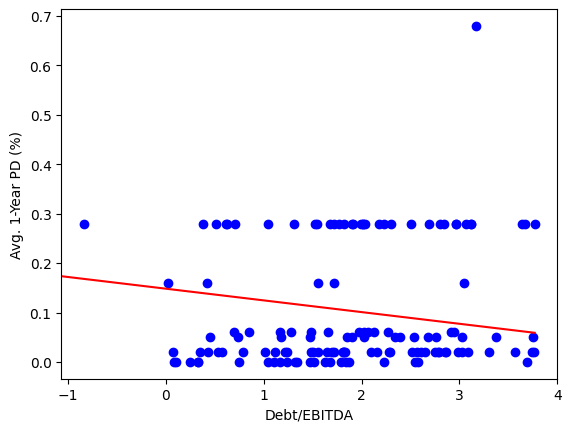

In [15]:

train_filtered = train[(train['Debt/EBITDA'] >= -1) & (train['Avg. 1-Year PD (%)'] < 1)]
plt.scatter(train_filtered['Debt/EBITDA'], train_filtered['Avg. 1-Year PD (%)'],  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Debt/EBITDA")
plt.ylabel("Avg. 1-Year PD (%)")
# Dynamic x-axis adjustment based on filtered data
x_min, x_max = train_filtered['Debt/EBITDA'].min(), train_filtered['Debt/EBITDA'].max()
x_range = x_max - x_min
plt.xlim(x_min - 0.05*x_range, x_max + 0.05*x_range)
plt.show()

In [16]:
y_hat = regr.predict(test[['Debt/EBITDA']])
x = np.asanyarray(test[['Debt/EBITDA']])
y = np.asanyarray(test[['Avg. 1-Year PD (%)']])
print("Mean squared error: %.4f" % np.mean(np.absolute(y_hat - y)** 2))
print('variance score: %.2f' % regr.score(x, y))
print("R2-score: %.2f" % regr.score(x, y))

Mean squared error: 1.4829
variance score: -0.05
R2-score: -0.05


c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [161]:

# Use the true labels from the test dataframe to avoid name collisions
# (other cells reuse the name `y` for unrelated data, causing the shape mismatch)
y_true = np.ravel(np.asanyarray(test[['Avg. 1-Year PD (%)']]))
y_pred = np.ravel(y_hat)

mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R2: {r2:.4f}")


MSE: 0.016677
RMSE: 0.129141
R2: -0.1778


In [154]:
print(mse)
print(rmse)

0.016677438518212663
0.1291411573365078


In [155]:

import numpy as np
y_mean = np.mean(y)
mse_baseline = np.mean((y - y_mean)**2)
print("MSE (baseline mean):", mse_baseline)
print("MSE (model):", np.mean((y - y_hat)**2))


MSE (baseline mean): 0.014160180055401664
MSE (model): 0.016677438518212663


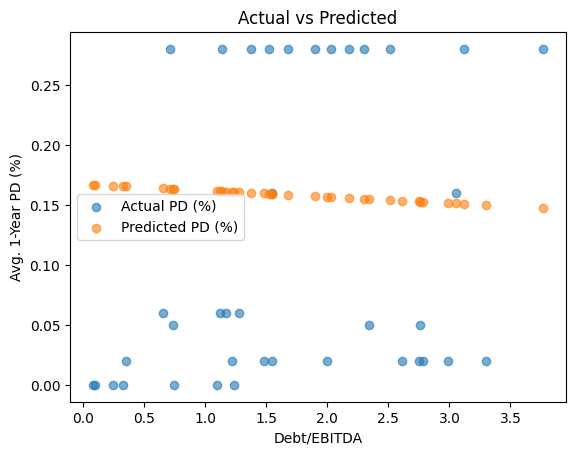

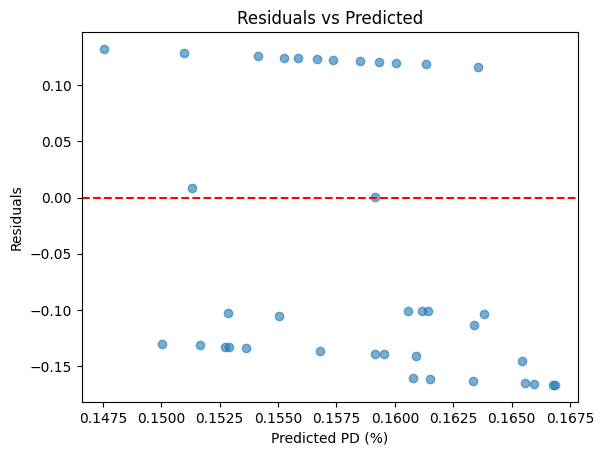

In [156]:

import matplotlib.pyplot as plt

plt.scatter(x, y, alpha=0.6, label='Actual PD (%)')
plt.scatter(x, y_hat, alpha=0.6, label='Predicted PD (%)')
plt.xlabel('Debt/EBITDA')
plt.ylabel('Avg. 1-Year PD (%)')
plt.legend(); plt.title('Actual vs Predicted'); plt.show()

resid = y - y_hat
plt.scatter(y_hat, resid, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted PD (%)'); plt.ylabel('Residuals')
plt.title('Residuals vs Predicted'); plt.show()


R²: 0.9678685098973752
RMSE: 0.46354453327538014
MAE: 0.3707007203653211
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1186.
Date:                Mon, 12 Jan 2026   Prob (F-statistic):          3.96e-107
Time:                        10:41:55   Log-Likelihood:                -120.37
No. Observations:                 160   AIC:                             248.7
Df Residuals:                     156   BIC:                             261.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

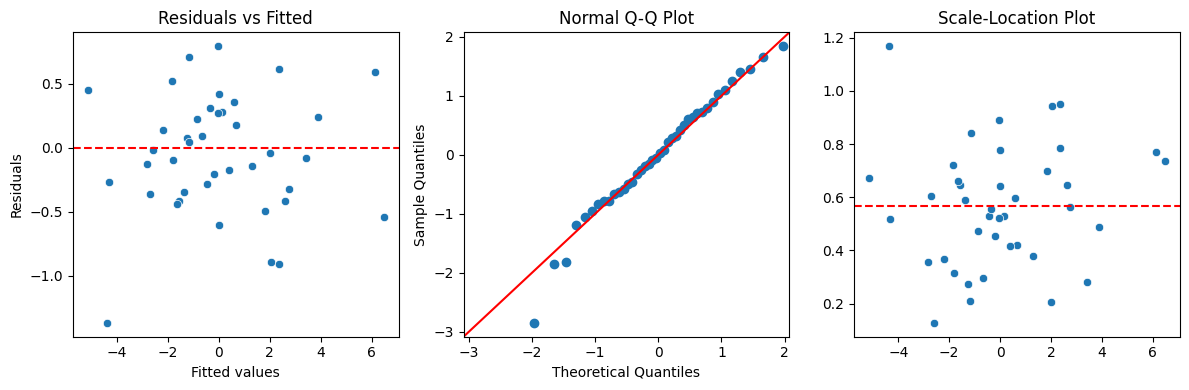

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

# Generate synthetic data
np.random.seed(42)
X = np.random.randn(200, 3)  # 3 features
y = 2*X[:,0] + 1.5*X[:,1] - 0.5*X[:,2] + np.random.randn(200)*0.5  # True relationship + noise

# Add column of ones for intercept in statsmodels
X_sm = sm.add_constant(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit with scikit-learn
model_sk = LinearRegression()
model_sk.fit(X_train, y_train)
y_pred = model_sk.predict(X_test)

# Metrics
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test, y_pred))

# Fit with statsmodels for p-values
model_sm = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model_sm.summary())  # Shows coefficients, p-values, R², Adjusted R², F-test

# Residual plots
residuals = y_test - y_pred
fitted = y_pred

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.subplot(1, 3, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Normal Q-Q Plot')

plt.subplot(1, 3, 3)
sns.scatterplot(x=fitted, y=np.sqrt(np.abs(residuals)))
plt.axhline(np.mean(np.sqrt(np.abs(residuals))), color='r', linestyle='--')
plt.title('Scale-Location Plot')

plt.tight_layout()
plt.show()